# Train a model from scratch

In this notebook we download a data file from the [NYC TLC trip record data website](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) and we train a model to predict the duration of a taxi ride.

## Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import pickle

## Download data from website

As an example, we will use Green Taxi data from January 2021 for training, and from February 2021 for validation.

In [2]:
!wget -NP ./data https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet
!wget -NP ./data https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet

--2023-05-16 17:46:48--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet
Resolviendo d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.67.246.167, 18.67.246.186, 18.67.246.47, ...
Conectando con d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)[18.67.246.167]:443... conectado.
Petición HTTP enviada, esperando respuesta... 304 Not Modified
Fichero “./data/green_tripdata_2021-01.parquet” no modificado en el servidor. Omitiendo la descarga.

--2023-05-16 17:46:49--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet
Resolviendo d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.67.246.47, 18.67.246.186, 18.67.246.176, ...
Conectando con d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)[18.67.246.47]:443... conectado.
Petición HTTP enviada, esperando respuesta... 304 Not Modified
Fichero “./data/green_tripdata_2021-02.parquet” no modificado en el servidor. Omitiendo la desc

## Read data into a dataframe

In [3]:
df = pd.read_parquet("./data/green_tripdata_2021-01.parquet")
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.50,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.50,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.50,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.50,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.00,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,2.75,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,0.00,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,2.75,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,2.75,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN


Next, we check we have the correct data types for each column.

In [4]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

## Calculate trip duration

In order to calculate the duration of each trip, we need to substract `lpep_pickup_datetime` from `lpep_dropoff_datetime`. Since these columns are already in the correct data type format (datetime), we don't need to do any previous transformation on them. We add the result to a new column, which we call `duration`.

In [5]:
df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,0 days 00:03:56
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,0 days 00:08:45
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,0 days 00:05:58
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,0 days 00:07:05
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0 days 00:00:04


We will use the duration of a trip in minutes as our target value for the model. For that, we convert the `duration` column values to the format we want.

In [6]:
td = df.duration.iloc[0]
td

Timedelta('0 days 00:03:56')

In [7]:
td.total_seconds()

236.0

In [8]:
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0.066667


## Check distribution of the target variable

Let's visualize the distribution of the trip duration data.

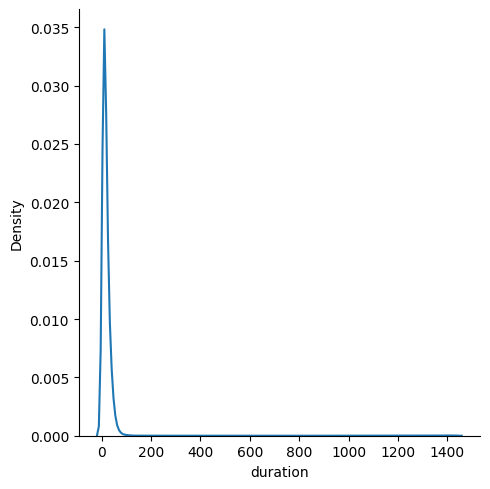

In [9]:
sns.displot(df.duration, kind="kde");

In [10]:
df.duration.describe(percentiles=[0.01, 0.02, 0.05, 0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
1%           0.200000
2%           1.016667
5%           3.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

We see that there is, at least, one really long trip and, on the other hand, there are trips which takes considerably less than a minute. So it may be useful to do some filtering. We will consider only trips that take more than 1 minute and less than 1 hour.

In [11]:
df = df[(df.duration >= 1) & (df.duration <= 60)]
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


## Feature selection

The next thing we do is to choose the variables, both categorical and numerical, that we will use to predict the target variable. We can find a description about each column in the [Green Taxi data dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf).

In our case, we choose the following variables:
* Categorical:
    + `PULocationID`.
    + `DOLocationID`.
* Numerical:
    + `trip_distance`.

In [12]:
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

## One Hot Encoding

In order to train a model, we need to transform our categorical values. We will implement [One Hot Encoding](https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/) on them by using the [`DictVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) method from `scikit-learn` library.

In [13]:
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [14]:
df.loc[:, categorical] = df.loc[:, categorical].astype(str)
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

We need to create dictionaries with our explanatory variables so that we can apply `DictVectorizer` on them.

In [15]:
train_dicts = df[categorical + numerical].to_dict(orient="records")
train_dicts[:5]

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45}]

In [16]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_train

<73908x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221724 stored elements in Compressed Sparse Row format>

## Code restructuring

Let's create a function for reading the data and having the dataframe ready for training and predictions, as we have done for our example, so that we can reuse it for different datasets.

In [17]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ["PULocationID", "DOLocationID"]
    df.loc[:, categorical] = df.loc[:, categorical].astype(str)
    
    return df

Now we can use the function to read our train and validation datasets.

In [18]:
df_train = read_dataframe("./data/green_tripdata_2021-01.parquet")
df_val = read_dataframe("./data/green_tripdata_2021-02.parquet")

In [19]:
len(df_train), len(df_val)

(73908, 61921)

And we can then apply the additional preprocessing steps to both dataframes.

In [20]:
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

## Set target variable

Next we create an array with the values of our target variable.

In [21]:
target = "duration"

y_train = df_train[target].values
y_val = df_val[target].values

## Train a linear regression model

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

## Predict

We use the validation dataset to make predictions and evaluate against the actual values.

In [23]:
y_pred = lr.predict(X_val)

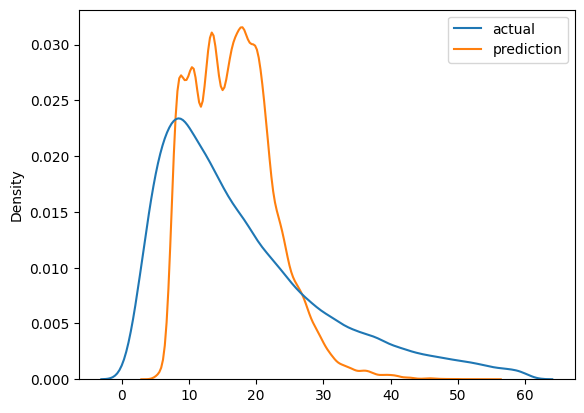

In [24]:
y = {"actual": y_val, "prediction": y_pred}
sns.kdeplot(data=y);

## Evaluate the model on the training dataset

In [25]:
mean_squared_error(y_val, y_pred, squared=False)

10.499110714431122

So, on average, there is an error of about 10.5 minutes in our predictions.

We can use this model as our baseline to compare with other models we train.

## Train an evaluate other models

Next, we train Lasso and Ridge regression models and evaluate the error of the predictions they output, so that we can compare the results with our baseline linear regression model.

In [26]:
lr = Lasso(alpha=0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

10.812725703916977

In [27]:
rr = Ridge(alpha=0.5)
rr.fit(X_train, y_train)

y_pred = rr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

10.475465165451817

## Try a different approach for the explanatory variables

Now we combine `PULocationID` and `DOLocationID` in just one categorical variable.

In [28]:
df_train["PU_DO"] = df_train["PULocationID"] + '_' + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + '_' + df_val["DOLocationID"]

In [29]:
df_val

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-02-01 00:34:03,2021-02-01 00:51:58,N,1.0,130,205,5.0,3.66,14.00,...,10.00,0.0,None,0.3,25.30,1.0,1.0,0.00,17.916667,130_205
1,2,2021-02-01 00:04:00,2021-02-01 00:10:30,N,1.0,152,244,1.0,1.10,6.50,...,0.00,0.0,None,0.3,7.80,2.0,1.0,0.00,6.500000,152_244
2,2,2021-02-01 00:18:51,2021-02-01 00:34:06,N,1.0,152,48,1.0,4.93,16.50,...,0.00,0.0,None,0.3,20.55,2.0,1.0,2.75,15.250000,152_48
3,2,2021-02-01 00:53:27,2021-02-01 01:11:41,N,1.0,152,241,1.0,6.70,21.00,...,0.00,0.0,None,0.3,22.30,2.0,1.0,0.00,18.233333,152_241
4,2,2021-02-01 00:57:46,2021-02-01 01:06:44,N,1.0,75,42,1.0,1.89,8.50,...,2.45,0.0,None,0.3,12.25,1.0,1.0,0.00,8.966667,75_42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64567,2,2021-02-28 22:19:00,2021-02-28 22:29:00,None,NaN,129,7,NaN,2.63,10.04,...,0.00,0.0,None,0.3,10.34,NaN,NaN,NaN,10.000000,129_7
64568,2,2021-02-28 23:18:00,2021-02-28 23:27:00,None,NaN,116,166,NaN,1.87,8.33,...,1.89,0.0,None,0.3,10.52,NaN,NaN,NaN,9.000000,116_166
64569,2,2021-02-28 23:44:00,2021-02-28 23:58:00,None,NaN,74,151,NaN,2.40,12.61,...,0.00,0.0,None,0.3,12.91,NaN,NaN,NaN,14.000000,74_151
64570,2,2021-02-28 23:07:00,2021-02-28 23:14:00,None,NaN,42,42,NaN,1.11,11.95,...,0.00,0.0,None,0.3,15.00,NaN,NaN,NaN,7.000000,42_42


In [30]:
categorical = ["PU_DO"]  # ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715204122913

As we can see, combining the categorical variables into one has helped us to achieve better results.

## Save model

Finally, we can save our model for deployment without the need to train it again.

In [32]:
with open("./models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)